# A Closer Look at Model-Based Policy Gradients

---
## Linear Quadratic Gaussian (LQG) Problems
In what follows we consider MDPs with:
1. continuous state space $\mathbf{s} \in \mathcal{S} = \mathbb{R}^n$
2. continuous action space $\mathbf{a} \in \mathcal{A} = \mathbb{R}^d$
3. finite time horizon $N \in \mathbb{N}$ and timesteps $t \in \mathcal{T} = \{0, \dots, N - 1\}$
4. time-varying linear Gaussian dynamics 
    $$
    \mathbf{s}_{t+1} \sim p(\cdot| \mathbf{s}_t, \mathbf{a}_t) = \mathcal{N}\left( \cdot ~\middle|~ \mathbf{F}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} + \mathbf{f}_t, \mathbf{\Sigma}_{t} \right)
    $$
5. time-varying quadratic costs 
    $$
    r_{t+1} = R(\mathbf{s}_t, \mathbf{a}_t) = - \tfrac{1}{2} \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}^\intercal \mathbf{C}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} - \mathbf{c}_t^\intercal \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}
    $$
6. Gaussian-distributed initial state 
    $$
    \mathbf{s}_0 \sim \rho = \mathcal{N}(\mathbf{\mu}_\rho, \mathbf{\Sigma}_\rho)
    $$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from gym.spaces import Box
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from torch import Tensor


import raylab
import lqsvg.envs.lqr.named as named
import lqsvg.torch.named as nt
from lqsvg.envs import lqr

In [2]:
seed = \
0
# 42
# 69
n_state, n_ctrl, horizon = 2, 2, 100
n_tau = n_state + n_ctrl

In [3]:
dynamics, cost = lqr.make_lqg(state_size=n_state, ctrl_size=n_ctrl, horizon=horizon, stationary=True, np_random=seed)
init = lqr.make_gaussinit(state_size=n_state, np_random=seed)

print(f"""
Dynamics:
    F: {dynamics.F.shape}, {dynamics.F.names}
    f: {dynamics.f.shape}, {dynamics.f.names}
    W: {dynamics.W.shape}, {dynamics.W.names}

Cost:
    C: {cost.C.shape}, {cost.C.names}
    c: {cost.c.shape}, {cost.c.names}
    
Initial state:
    mean: {init.mu.shape}, {init.mu.names}
    covariance: {init.sig.shape}, {init.sig.names}
""")


Dynamics:
    F: torch.Size([100, 2, 4]), ('H', 'R', 'C')
    f: torch.Size([100, 2]), ('H', 'R')
    W: torch.Size([100, 2, 2]), ('H', 'R', 'C')

Cost:
    C: torch.Size([100, 4, 4]), ('H', 'R', 'C')
    c: torch.Size([100, 4]), ('H', 'R')
    
Initial state:
    mean: torch.Size([2]), ('R',)
    covariance: torch.Size([2, 2]), ('R', 'C')



/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-kEsPsxvA-py3.8/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:930.)
  return super(Tensor, self).refine_names(names)


## Time-varying linear policy

A time-varying linear policy is a mapping $\mu_\theta: \mathcal{S}\times\mathcal{T} \mapsto \mathcal{A}$ such that
$$
    \mu_\theta(\mathbf{s}, t) = \mathbf{K}_t \mathbf{s} + \mathbf{k}_t
    \,,
$$
where $\mathbf{K}_t \in \mathbb{R}^{d\times n}$, $\mathbf{k}_t \in \mathbb{R}^d$ and $\theta = \{\mathbf{K}_t, \mathbf{k}_t\}_{t\in\mathcal{T}}$.

In [4]:
from lqsvg.policy.time_varying_linear import TVLinearFeedback

## Quadratic State-value

$$
        V^\mu(\mathbf{s}, t) = {\tfrac12} \mathbf{s}^\intercal\mathbf{V}_t\mathbf{s} + \mathbf{v}_t^\intercal\mathbf{s} + v_t, \quad t\in\mathcal{T}^+ \,,
$$

In [5]:
from typing import Optional

class ValueFn(nn.Module):
    def __init__(self, quadratic: lqr.Quadratic, timestep: int = 0):
        super().__init__()
        V, v, c = (x.select("H", timestep) for x in quadratic)
        self.register_buffer("V", V.align_to("R", "C"))
        self.register_buffer("v", v.align_to("R", "C"))
        self.register_buffer("c", c.align_to("R", "C"))
        assert len(self.V.shape) == len(self.v.shape) == len(self.c.shape) == 2, \
            (self.V.shape, self.v.shape, self.c.shape)
        
    def symeig(self) -> Tensor:
        return torch.symeig(self.V.rename(None))

    def forward(self, state: Tensor):
        """Calculate optimal state-value.

        May be used with batched states.
        """
        s = nt.vector_to_matrix(state)
        value = nt.transpose(s) @ self.V @ s / 2 \
                + nt.transpose(self.v) @ s \
                + self.c
        return nt.matrix_to_scalar(value)
    
    def min(self):
        Vinv = nt.unnamed(self.V).inverse()
        return nt.matrix_to_vector(-Vinv @ self.v)
    
    def expected(self, init: lqr.GaussInit):
        """Expected cost given mean and covariance matrix of the initial state.
        
        https://en.wikipedia.org/wiki/Quadratic_form_(statistics)#Expectation.
        """
        mean = nt.vector_to_matrix(init.mu)
        cov = init.sig
        value = nt.scalar_to_matrix(nt.trace(cov @ self.V)) / 2 \
            + nt.transpose(mean) @ self.V @ mean \
            + nt.transpose(self.v) @ mean \
            + self.c
        return nt.matrix_to_scalar(value)
            
    def plot_3d(self, ax, mean: Optional[Tensor] = None, amp: float = 10):
        if mean is None:
            mean = self.min().detach().numpy()
        else:
            mean = mean.detach().numpy()

        xrange = np.linspace(mean[0] -amp, mean[0] + amp, num=100)
        yrange = np.linspace(mean[1] -amp, mean[1] + amp, num=100)
        xbatch, ybatch = np.meshgrid(xrange, yrange)
        assert xbatch.shape == ybatch.shape == (100, 100)

        init_states = np.stack([xbatch, ybatch], axis=-1).reshape((-1, 2))
        init_states = torch.from_numpy(init_states).float().refine_names("B", "R")
        assert init_states.shape == (10000, 2), init_states.shape

        init_values = self(init_states).detach().numpy()
        assert init_values.shape == (10000,), init_values.shape

        init_values = init_values.reshape(xbatch.shape)
        ax.plot_surface(xbatch, ybatch, init_values, cmap=cm.coolwarm)
        
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("value")

# Exact methods
---
## LQG control

<img src="images/LQG - Control.png" width=800>

In [6]:
def print_solution(policy, qval, vval):
    K, k = policy
    Q, q, qc = qval
    V, v, vc = vval
    
    print(f"""
    Policy:
        K: {K.shape}, {K.names}
        k: {k.shape}, {k.names}
    """)
    
    print(f"""
    Q-value:
        Q: {Q.shape}, {Q.names}
        q: {q.shape}, {q.names}
        const: {qc.shape}, {qc.names}
    """)

    print(f"""
    V-value:
        V: {V.shape}, {V.names}
        V: {v.shape}, {v.names}
        const: {vc.shape}, {vc.names}
    """)

In [7]:
lqg_control = lqr.NamedLQGControl(n_state, n_ctrl, horizon)
pistar, qstar, vstar = lqg_control(dynamics, cost)
print_solution(pistar, qstar, vstar)


    Policy:
        K: torch.Size([100, 2, 2]), ('H', 'R', 'C')
        k: torch.Size([100, 2]), ('H', 'R')
    

    Q-value:
        Q: torch.Size([100, 4, 4]), ('H', 'R', 'C')
        q: torch.Size([100, 4]), ('H', 'R')
        const: torch.Size([100]), ('H',)
    

    V-value:
        V: torch.Size([101, 2, 2]), ('H', 'R', 'C')
        V: torch.Size([101, 2]), ('H', 'R')
        const: torch.Size([101]), ('H',)
    


In [8]:
vstar_fn = ValueFn(vstar)
print(vstar_fn.V)
print(vstar_fn.v)
print(vstar_fn.c)

tensor([[0.7519, 0.0669],
        [0.0669, 0.4993]], names=('R', 'C'))
tensor([[ 0.4185],
        [-0.0853]], names=('R', 'C'))
tensor([[108.5435]], names=('R', 'C'))


### Optimal value for best initial state
$$
\begin{align}
\mathbf{s}_{min} 
&= \arg\min_{\mathbf{s}} V^\star(\mathbf{s}, 0) \\
&= \arg\min_{\mathbf{s}} \mathbf{s}^\intercal \mathbf{V}_0^\star \mathbf{s} + {\mathbf{v}_0^\star}^\intercal \mathbf{s} + v_0^\star \\
&= -{\mathbf{V}_0^\star}^{-1} \mathbf{v}_0^\star \\
\end{align}
$$

In [9]:
minimum = vstar_fn.min()
print(f"""
    Best initial state: {minimum}
    Best initial value: {vstar_fn(minimum)}
""")


    Best initial state: tensor([-0.5786,  0.2483], names=('R',))
    Best initial value: 108.41183471679688



### Optimal expected initial state value
$$
\mathbb{E}_{\mathbf{s}\sim\rho} \left[ V^{\star}(\mathbf{s}, 0) \right]
= \text{Tr}(\mathbf{V}_0\mathbf{\Sigma}_0) + \mathbf{\mu}_0^\intercal \mathbf{V}_0 \mathbf{\mu}_0 + \mathbf{v}_0^\intercal \mathbf{\mu}_0 + v_0
$$

In [10]:
print(f"""
    Mean: {init.mu}
    Covariance: {init.sig}
    Expected value: {vstar_fn.expected(init)}
""")


    Mean: tensor([0., 0.], names=('R',))
    Covariance: tensor([[1., 0.],
        [0., 1.]], names=('R', 'C'))
    Expected value: 109.16909790039062



### Optimal value for each initial state

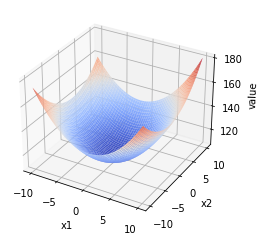

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
vstar_fn.plot_3d(ax, mean=init.mu)
# plt.savefig("navigation2d_value.png")
plt.show()

In [12]:
print(vstar_fn.symeig())

torch.return_types.symeig(
eigenvalues=tensor([0.4827, 0.7686]),
eigenvectors=tensor([]))


## LQG prediction (Policy Evaluation)

<img src="images/LQG - Prediction.png" width=800>

In [13]:
lqg_prediction = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)

## Perturbed optimal policies

We generate sub-optimal policies by adding uniform noise to the optimal policy's parameters, i.e., 
$$
    \mathbf{K}_t = \mathbf{K}_t^\star + \epsilon, \qquad \epsilon \sim \mathcal{U}(\mathbf{0}, \mathbf{0.5}) \\
    \mathbf{k}_t = \mathbf{k}_t^\star + \epsilon, \qquad \epsilon \sim \mathcal{U}(\mathbf{0}, \mathbf{0.5})
$$

In [14]:
def rand_policy(policy, seed):
    K, k = policy
    torch.manual_seed(seed)
    K = K + torch.rand_like(K) * 0.5
    k = k + torch.rand_like(k) * 0.5
    return (K, k)

In [15]:
policy = rand_policy(pistar, seed=seed)

_, vval = lqg_prediction(policy, dynamics, cost)
vval_fn = ValueFn(vval)
min_state = vval_fn.min()
print(f"""
    V: {vval_fn.V}
    v: {vval_fn.v}
    c: {vval_fn.c}
    
    min state: {min_state}
    min value: {vval_fn(min_state)}
""")


    V: tensor([[1.3181, 1.0737],
        [1.0737, 2.3034]], names=('R', 'C'))
    v: tensor([[-2.4610],
        [-5.6640]], names=('R', 'C'))
    c: tensor([[2056.7476]], names=('R', 'C'))
    
    min state: tensor([-0.2192,  2.5611], names=('R',))
    min value: 2049.76416015625



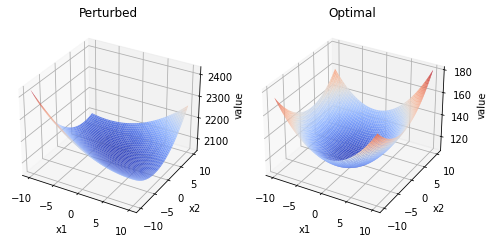

In [16]:
fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(1, 2, 1, projection="3d")
vval_fn.plot_3d(ax, mean=init.mu)
ax.set_title("Perturbed")

ax = fig.add_subplot(1, 2, 2, projection="3d")
vstar_fn.plot_3d(ax, mean=init.mu)
ax.set_title("Optimal")

# plt.savefig("navigation2d_value.png")
plt.show()

In [17]:
print(vval_fn.symeig())
print(vstar_fn.symeig())

torch.return_types.symeig(
eigenvalues=tensor([0.6294, 2.9921]),
eigenvectors=tensor([]))
torch.return_types.symeig(
eigenvalues=tensor([0.4827, 0.7686]),
eigenvectors=tensor([]))


## Policy learning via true value gradients

LQG prediction can be seen as a function mapping policy parameters (with the dynamics kept constant) to value function coefficients:
$$
\left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right) = \text{LQGPrediction}(\theta)
$$

Thus, we can write each coeficient as a function of policy parameters. For example, the value function for a policy $\mu_\theta$ would be:
$$
V^\mu(\mathbf{s}, t) = \tfrac12 \mathbf{s}^\intercal \mathbf{V}_t(\theta) \mathbf{s} + \mathbf{v}_t(\theta)^\intercal \mathbf{s} + v_t(\theta)
$$

We can then express policy performance as a direct function of policy parameters:
$$
\begin{align}
J(\theta) 
    &= \mathbb{E}_{\mathbf{s}\sim\rho} \left[ \tfrac12 \mathbf{s}^\intercal \mathbf{V}_0(\theta) \mathbf{s} + \mathbf{v}_0(\theta)^\intercal \mathbf{s} + v_0(\theta) \right] \\
    &= \text{Tr}(\mathbf{V}_0(\theta)\mathbf{\Sigma}_0) + \mathbf{\mu}_0^\intercal \mathbf{V}_0(\theta) \mathbf{\mu}_0 + \mathbf{v}_0(\theta)^\intercal \mathbf{\mu}_0 + v_0(\theta)
\end{align}
$$

In [18]:
class TVLFLoss(nn.Module):
    def __init__(
        self, 
        dynamics: lqr.LinDynamics,
        cost: lqr.QuadCost,
        init: lqr.GaussInit,
    ):
        super().__init__()
        n_state = dynamics.F.size("R")
        n_ctrl = dynamics.F.size("C") - n_state
        horizon = dynamics.F.size("H")
        self.predict = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)
        self.dynamics = dynamics
        self.cost = cost
        self.init = init
        
    def forward(self, policy: lqr.Linear):
        _, vval = self.predict(policy, self.dynamics, self.cost)
        vval_fn = ValueFn(vval)
        cost = vval_fn.expected(self.init)
        return cost

In [19]:
loss_fn = TVLFLoss(dynamics, cost, init)
loss = loss_fn(policy)
print("Random policy loss:", loss)

Random policy loss: tensor(2058.5583)


Finally, since the value function coefficients are differentiable functions of the policy parameters, we can optimize the latter for better performance via gradient ascent
$$
\theta \gets \theta + \alpha \nabla_{\theta} J(\theta)
$$

In [20]:
tvlp = TVLinearFeedback.from_existing(policy)
optim = torch.optim.Adam(tvlp.parameters(), lr=1e-3)

for i in range(100):
# for i in range(1):
    for p in tvlp.parameters():
        p.grad = None
    loss = loss_fn(tvlp.gains())
    loss.backward()
    optim.step()
    if i % 100 == 0:
        print("Loss:", loss.item())
print("Loss:", loss_fn(tvlp.gains()).item())
print("Best possible:", vstar_fn.expected(loss_fn.init).item())

Loss: 2058.558349609375
Loss: 317.6082458496094
Best possible: 109.16909790039062


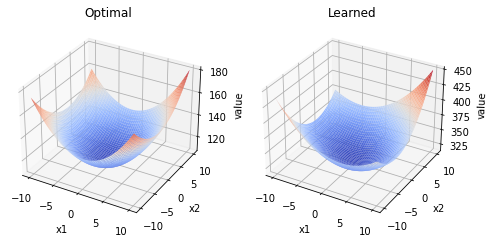

In [21]:
learned_vval = ValueFn(lqg_prediction(tvlp.gains(), dynamics, cost)[1])
fig = plt.figure(figsize=(8, 16))

ax = fig.add_subplot(1, 2, 1, projection="3d")
vstar_fn.plot_3d(ax, mean=init.mu)
ax.set_title("Optimal")

ax = fig.add_subplot(1, 2, 2, projection="3d")
learned_vval.plot_3d(ax, mean=init.mu)
ax.set_title("Learned")

plt.show()